In [41]:
import pandas as pd
import numpy as np

np.random.seed(1)

In [79]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
seaLvl = pd.read_csv('sea_levels_2015.csv', header = 0, parse_dates = ['Time'], date_parser = dateparser)
seaLvl['Year'] = seaLvl['Time'].apply(lambda x: x.year)
seaLvl['Month'] = seaLvl['Time'].apply(lambda x: x.month)
seaLvl = seaLvl.drop(['Time'], axis = 1)

seaLvl.head()

<ipython-input-79-b01a6b46929d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")


,GMSL,GMSL uncertainty,Year,Month
0,-183.0,24.2,1880,1
1,-171.1,24.2,1880,2
2,-164.3,24.2,1880,3
3,-158.2,24.2,1880,4
4,-158.7,24.2,1880,5


In [80]:
seaIce = pd.read_csv('seaice.csv')
seaIce.columns = [x.strip() for x in list(seaIce.columns)]

grp = seaIce.groupby(['Year', 'Month'])
seaIce = grp.agg("mean").reset_index()
seaIce.drop(columns=['Day', 'Missing'], inplace = True)

seaIce.head()

,Year,Month,Extent
0,1978,10,14.050833
1,1978,11,13.770767
2,1978,12,12.031156
3,1979,1,10.408100
4,1979,2,9.658179


In [81]:
temp = pd.read_csv('GlobalTemperatures.csv', header = 0, parse_dates = ['dt'], date_parser = dateparser)
temp['Year'] = temp['dt'].apply(lambda x: x.year)
temp['Month'] = temp['dt'].apply(lambda x: x.month)
temp = temp[['Year', 'Month', 'LandAverageTemperature']]

temp.head()

<ipython-input-79-b01a6b46929d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")


,Year,Month,LandAverageTemperature
0,1750,1,3.034
1,1750,2,3.083
2,1750,3,5.626
3,1750,4,8.490
4,1750,5,11.573


In [82]:
data = seaLvl.merge(seaIce, how = 'inner').merge(temp, how = 'inner')

In [83]:
data.head()

,GMSL,GMSL uncertainty,Year,Month,Extent,LandAverageTemperature
0,-17.7,6.7,1978,10,14.050833,9.339
1,-22.2,6.7,1978,11,13.770767,6.350
2,-25.2,6.7,1978,12,12.031156,3.740
3,-28.0,6.7,1979,1,10.408100,2.679
4,-26.9,6.7,1979,2,9.658179,2.841


# Correlation Matrix

In [84]:
# compute percent changes of both series
# data['GMSL_Ret'] = data['GMSL'].pct_change()
# data['Extent_Ret'] = data['Extent'].pct_change()



In [85]:
data

,GMSL,GMSL uncertainty,Year,Month,Extent,LandAverageTemperature
0,-17.7,6.7,1978,10,14.050833,9.339
1,-22.2,6.7,1978,11,13.770767,6.350
2,-25.2,6.7,1978,12,12.031156,3.740
3,-28.0,6.7,1979,1,10.408100,2.679
4,-26.9,6.7,1979,2,9.658179,2.841
...,...,...,...,...,...,...
418,71.6,8.8,2013,8,12.338645,14.742
419,68.8,8.8,2013,9,12.298467,13.154
420,66.4,8.9,2013,10,13.236306,10.256
421,59.7,9.0,2013,11,13.405600,7.424


In [86]:
import matplotlib.pyplot as plt

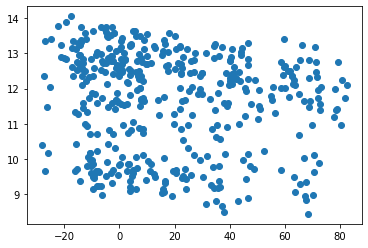

In [87]:
plt.scatter(data['GMSL'], data['Extent'])
plt.show()

In [102]:
a = pd.DataFrame(columns = ['Rank'],  
                   index = [i for i in range(10)])
for i in range(10):
    a.loc[i] = i
a


,Rank
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [105]:
def spearsmans_rank_correlation(x, y):
    """Returns the spearsmans rank correlation of <x> and <y>
       using the r = 1 - 6*Sigma(di^2)/(n(n^2 - 1))
    """
    n = len(x)
    d_sigma = ((rankify(x) - rankify(y)) ** 2).sum()
    r = 1 - (6 * d_sigma) / (n * (n ** 2 - 1))
    return r

def rankify(df):
    """Returns a pandas dataframe that has the ranking of <df>
    """
    n = len(df)
    # create an empty dataframe with n rows
    rank_df = pd.DataFrame(columns = ['Rank'],  
                   index = [i for i in range(n)])
    
    for i in range(n):
        # initialize the rank and same element to be 1
        rank, same = 1, 1
        # compare ranks
        for j in range(n):
            if i != j:
                if df.iloc[j] < df.iloc[i]:
                    rank += 1
                elif df.iloc[j] == df.iloc[i]:
                    same += 1
        
        # using fractional ranking scheme
        rank_df.iloc[i] = rank + (same - 1) / 2
    
    return rank_df
    

In [128]:
a = spearsmans_rank_correlation(data['GMSL'], data['Extent'])


In [124]:
import seaborn as sn

In [125]:
def generate_correlation_matrix(data, label):
    matrix = pd.DataFrame(columns = label, index = label)
    for i in range(len(label)):
        for j in range(i, len(label)):
            r = spearsmans_rank_correlation(data.iloc[:][label[i]], data.iloc[:][label[j]]).values[0]
            matrix.iloc[i][j] = r
            if i != j:
                matrix.iloc[j][i] = r
    return matrix

        
label = ['GMSL', 'Extent', 'LandAverageTemperature']
corrMatrix = generate_correlation_matrix(data, label)

# or calling pandas correlation function
#data[['GMSL', 'Extent', 'LandAverageTemperature']].corr(method='spearman')

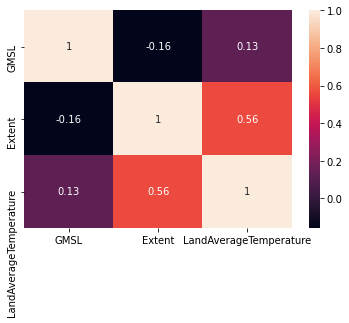

In [127]:
corrMatrix = data[['GMSL', 'Extent', 'LandAverageTemperature']].corr(method='spearman')
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [89]:
print(correlation)

nan


In [90]:
def normalize(d):
    return (np.array(d) - np.mean(np.array(d)))/np.std(np.array(d))

In [91]:
data['GMSL'] = normalize(data['GMSL'])
data['Extent'] = normalize(data['Extent'])
data['LandAverageTemperature'] = normalize(data['LandAverageTemperature'])

,GMSL,Extent,LandAverageTemperature
GMSL,1.000000,-0.156803,0.125853
Extent,-0.156803,1.000000,0.562522
LandAverageTemperature,0.125853,0.562522,1.000000


In [9]:
y = data['GMSL'][1:].values
x = data[['GMSL','Extent','LandAverageTemperature']].iloc[:-1,:].values

In [10]:
x.shape, y.shape

((422, 3), (422,))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((337, 3), (85, 3), (337,), (85,))

In [17]:
D = 3
M = 2
K = 1
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)
learning_rate = 0.002

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def forward(X, W1, b1, W2, b2):
    
    Z = sigmoid(X.dot(W1) + b1)
    A = Z.dot(W2) + b2
    A = np.array([x for l in A for x in l])
    
    return Z, A


def cost(y_true, y_est):
    return (0.5*(y_true - y_est)**2).sum()


def derivative_W2(Z, T, Y):
    
    v = Z.T.dot(T - Y).reshape(-1,1)
    
#     n = T.shape[0]
#     v = np.zeros((M,K))
#     for t in range(n):
#         for h in range(M):
#             v[h, 0] += (np.array(T)[t] - Y[t])*Z[t,h]
            
    return v


def derivative_b2(T, Y):
    
    return (T - Y).sum()


def derivative_W1(X, Z, T, Y, W2):
    
    n = X.shape[0]
    
#     w = np.zeros((D, M))
#     for t in range(n):
#         for h in range(M):
#             for j in range(D):
#                 w[j, h] += (np.array(T)[t] - Y[t])*W2[h,0]*Z[t,h]*(1-Z[t,h])*X[t,j]
        
    w = X.T.dot((T - Y).reshape(-1,1).dot(W2.T) * Z * (1 - Z))
    
    return w

def derivative_b1(Z, T, Y, W2):
    
    return ((T - Y).reshape(-1,1).dot(W2.T) * Z * (1 - Z)).sum(axis=0)

Trained variables:
W1: 
 [[-1.48519678 -1.00869123]
 [-0.73741339  0.22632796]
 [-0.2759776   0.06574208]]
b1: 
 [-0.10597733  0.49127315]
W2: 
 [[-1.05518711]
 [-3.40806634]]
b2: 
 [2.5834119]


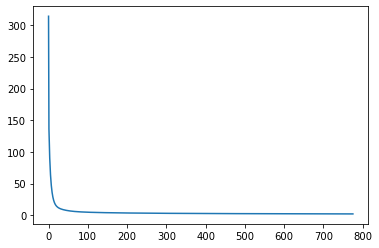

In [18]:
import matplotlib.pyplot as plt
err_threshold = 2

costs = []
for epoch in range(1000):
    hidden, output = forward(X_train, W1, b1, W2, b2)
    costs.append(cost(y_train, output))
    
    if cost(y_train, output) < err_threshold:
        print('Trained variables:')
        print('W1: \n', W1)
        print('b1: \n', b1)
        print('W2: \n', W2)
        print('b2: \n', b2)
        break
        
    W2 += learning_rate * derivative_W2(hidden, y_train, output)
    b2 += learning_rate * derivative_b2(y_train, output)
    W1 += learning_rate * derivative_W1(X_train, hidden, y_train, output, W2)
    b1 += learning_rate * derivative_b1(hidden, y_train, output, W2)
    
    
plt.plot(costs)
plt.show()

In [19]:
costs

[314.1565056306429,
 136.43904233989247,
 110.18119026509648,
 90.48003859855929,
 75.45948868661847,
 63.779846483224034,
 54.536927776005456,
 47.115150848799544,
 41.08643767309211,
 36.14481682979899,
 32.06535203013792,
 28.678308645142245,
 25.85266536036106,
 23.485366256660413,
 21.494137999818868,
 19.812554834371447,
 18.386546288736334,
 17.171850287251488,
 16.132101049803413,
 15.237355352140165,
 14.462931043882403,
 13.788475279502872,
 13.197207065684601,
 12.67529579500173,
 12.21134830653353,
 11.795984076288423,
 11.421482857509195,
 11.081492355924663,
 10.770785879652191,
 10.485061674923271,
 10.22077704413813,
 9.975011460899129,
 9.745353820240767,
 9.529809736706563,
 9.326725457870904,
 9.134725516880279,
 8.952661719779158,
 8.779571463783583,
 8.614643721235574,
 8.45719130927582,
 8.306628304799755,
 8.16245166460614,
 8.024226277610952,
 7.891572814667472,
 7.764157856335082,
 7.64168587370369,
 7.523892715397865,
 7.410540317959249,
 7.3014124093166135,
 

In [ ]:
#Test Data

In [ ]:
#5 Fold

In [76]:
x = list(data['GMSL'])

def input_generator_2D(seq, n):
    
    input_x = list()
    input_y = list()

    for i in range(len(seq)-n):

        input_x.append(seq[i:i+n])
        input_y.append(seq[i+n])
        
    return np.array(input_x), np.array(input_y)

In [77]:
x, y = input_generator_2D(x, 3)
print(x)
print(y)

[[-17.7 -22.2 -25.2]
 [-22.2 -25.2 -28. ]
 [-25.2 -28.  -26.9]
 ...
 [ 71.2  71.6  68.8]
 [ 71.6  68.8  66.4]
 [ 68.8  66.4  59.7]]
[-28.  -26.9 -25.8 -26.1 -27.5 -27.1 -24.7 -19.9 -17.3 -14.9 -17.2 -15.
 -15.2 -14.1 -16.1 -15.8 -16.1 -16.7 -19.2 -21.  -21.  -19.2 -14.   -9.9
  -7.8  -6.8  -5.   -4.   -2.7  -2.2  -3.9  -3.1  -4.1  -2.   -2.9  -4.4
  -8.2  -9.3 -10.6 -13.1 -13.5 -14.7 -15.8 -14.4 -10.3  -4.7  -2.1  -1.6
   0.2  -0.5   1.1   4.3   7.5   6.    1.8  -5.9  -6.7  -9.7  -6.8  -8.9
  -7.5  -6.3  -3.   -2.2  -1.2   1.    0.6   2.   -0.2  -1.1  -4.4  -6.4
 -10.4  -9.5 -11.7 -11.7 -13.5 -13.1 -13.7 -15.4 -14.6 -13.9 -12.5 -12.2
 -10.8  -9.7 -10.3 -10.5 -11.8 -11.  -13.3 -12.5 -13.5 -13.9 -14.3 -13.1
 -11.2  -8.5 -10.8 -12.4 -10.9  -9.3  -8.2 -13.5 -15.3 -16.7 -12.1  -8.6
  -9.1  -7.8  -9.9  -8.2  -8.1  -6.6  -6.4  -4.8  -3.3  -2.6  -4.9  -9.4
  -9.4  -8.   -2.4  -1.6  -1.1  -3.   -2.7  -1.    0.3   0.6   1.1  -0.6
  -0.2  -2.6  -4.4  -3.9  -4.1  -0.   -0.2   2.8   3.    3.8   4.3

In [78]:
x = np.array(list(map(list, zip(data['GMSL'], data['Extent'], data['LandAverageTemperature']))))

In [79]:
def input_generator_3D(seq, n):
    
    input_x = list()
    input_y = list()

    for i in range(len(seq)-n):

        input_x.append(seq[i:i+n, :])
        input_y.append(seq[i+n, 0])

    return np.array(input_x), np.array(input_y)

In [80]:
x, y = input_generator_3D(x, 3)

In [81]:
x

array([[[-17.7       ,  14.05083333,   9.339     ],
        [-22.2       ,  13.77076667,   6.35      ],
        [-25.2       ,  12.03115625,   3.74      ]],

       [[-22.2       ,  13.77076667,   6.35      ],
        [-25.2       ,  12.03115625,   3.74      ],
        [-28.        ,  10.4081    ,   2.679     ]],

       [[-25.2       ,  12.03115625,   3.74      ],
        [-28.        ,  10.4081    ,   2.679     ],
        [-26.9       ,   9.65817857,   2.841     ]],

       ...,

       [[ 71.2       ,  12.4701129 ,  15.003     ],
        [ 71.6       ,  12.33864516,  14.742     ],
        [ 68.8       ,  12.29846667,  13.154     ]],

       [[ 71.6       ,  12.33864516,  14.742     ],
        [ 68.8       ,  12.29846667,  13.154     ],
        [ 66.4       ,  13.23630645,  10.256     ]],

       [[ 68.8       ,  12.29846667,  13.154     ],
        [ 66.4       ,  13.23630645,  10.256     ],
        [ 59.7       ,  13.4056    ,   7.424     ]]])

In [82]:
y

array([-28. , -26.9, -25.8, -26.1, -27.5, -27.1, -24.7, -19.9, -17.3,
       -14.9, -17.2, -15. , -15.2, -14.1, -16.1, -15.8, -16.1, -16.7,
       -19.2, -21. , -21. , -19.2, -14. ,  -9.9,  -7.8,  -6.8,  -5. ,
        -4. ,  -2.7,  -2.2,  -3.9,  -3.1,  -4.1,  -2. ,  -2.9,  -4.4,
        -8.2,  -9.3, -10.6, -13.1, -13.5, -14.7, -15.8, -14.4, -10.3,
        -4.7,  -2.1,  -1.6,   0.2,  -0.5,   1.1,   4.3,   7.5,   6. ,
         1.8,  -5.9,  -6.7,  -9.7,  -6.8,  -8.9,  -7.5,  -6.3,  -3. ,
        -2.2,  -1.2,   1. ,   0.6,   2. ,  -0.2,  -1.1,  -4.4,  -6.4,
       -10.4,  -9.5, -11.7, -11.7, -13.5, -13.1, -13.7, -15.4, -14.6,
       -13.9, -12.5, -12.2, -10.8,  -9.7, -10.3, -10.5, -11.8, -11. ,
       -13.3, -12.5, -13.5, -13.9, -14.3, -13.1, -11.2,  -8.5, -10.8,
       -12.4, -10.9,  -9.3,  -8.2, -13.5, -15.3, -16.7, -12.1,  -8.6,
        -9.1,  -7.8,  -9.9,  -8.2,  -8.1,  -6.6,  -6.4,  -4.8,  -3.3,
        -2.6,  -4.9,  -9.4,  -9.4,  -8. ,  -2.4,  -1.6,  -1.1,  -3. ,
        -2.7,  -1. ,

# Matrix Learning

In [23]:
def helper(v1, v2):
    print(v1, v2)
    res = 0
    for i in range(len(v1)):
        res += v1[i] * v2[i]
    return res
    

def compute_matrix(n1, n2):
    res = []
    for i in range(len(n1)):
        col = []
        for j in range(len(n2[0])):
            col.append(helper(n1[i], [r[j] for r in n2]))
        res.append(col)
    return res

n1 = [[1, 2, 3],
      [3, 2, 1]]

n2 = [[1, 1],
      [2, 2],
      [3, 3]]
print(compute_matrix(n1, n2))
            

[1, 2, 3] [1, 2, 3]
[1, 2, 3] [1, 2, 3]
[3, 2, 1] [1, 2, 3]
[3, 2, 1] [1, 2, 3]
[[14, 14], [10, 10]]
